In [1]:
import numpy as np
import pickle
import torch

# Get the interactive Tools for Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9.5, 6]

In [2]:
class Vocabulary(object):
    def __init__(self, pad_token='<pad>', unk_token='<unk>', eos_token='<eos>'):
        self.token2idx = {}
        self.idx2token = []
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.eos_token = eos_token
        if pad_token is not None:
            self.pad_index = self.add_token(pad_token)
        if unk_token is not None:
            self.unk_index = self.add_token(unk_token)
        if eos_token is not None:
            self.eos_index = self.add_token(eos_token)

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def get_index(self, token):
        if isinstance(token, str):
            return self.token2idx.get(token, self.unk_index)
        else:
            return [self.token2idx.get(t, self.unk_index) for t in token]

    def __len__(self):
        return len(self.idx2token)

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.__dict__, f)

    def load(self, filename):
        with open(filename, 'rb') as f:
            self.__dict__.update(pickle.load(f))

We will use the vocabulary computed by the Text Preprocessing notebook (text-preprocessing), and the word vectors computed by the CBOW Training notebook (cbow-vectors)

In [3]:
DATASET_VERSION = 'ca-100'
CBOW_VOCABULARY_ROOT = f'../input/text-preprocessing/data/{DATASET_VERSION}'
CBOW_VECTORS_ROOT = f'../input/cbow-training/data/{DATASET_VERSION}'

In [4]:
dict = f'{CBOW_VOCABULARY_ROOT}/ca.wiki.train.tokens.nopunct.dic'
counter = pickle.load(open(dict, 'rb'))
words, values = zip(*counter.most_common(5000))
print('Most frequent Catalan words')
print(words[:10])
print(values[:10])

Most frequent Catalan words
('de', 'la', 'i', 'a', 'el', 'd', 'l', 'que', 'en', 'va')
(5029788, 2771563, 2495802, 2130330, 1704858, 1362665, 1322822, 1293716, 1266356, 1191615)


In [5]:
from scipy.stats import entropy
h = entropy(values)
print(f'Word entropy: {h:5.2f}, Perplexity: {np.exp(h):5.0f}')
print(f'Probability of the most frequent word: {values[0]/sum(values):2.3f}')

Word entropy:  6.22, Perplexity:   505
Probability of the most frequent word: 0.076


**Zipf's law of words**. Zipf's law was originally formulated in terms of quantitative linguistics, stating that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table.

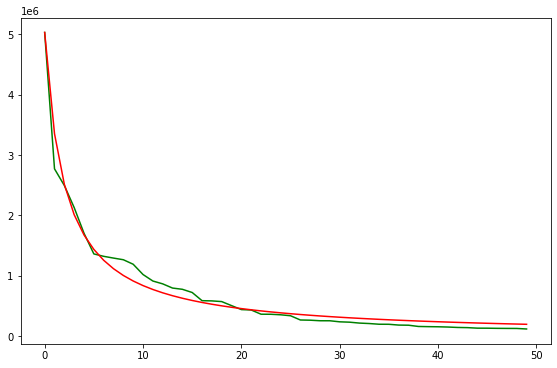

In [6]:
_ = plt.plot(values[:50], 'g', 2*values[0]/np.arange(2,52), 'r')

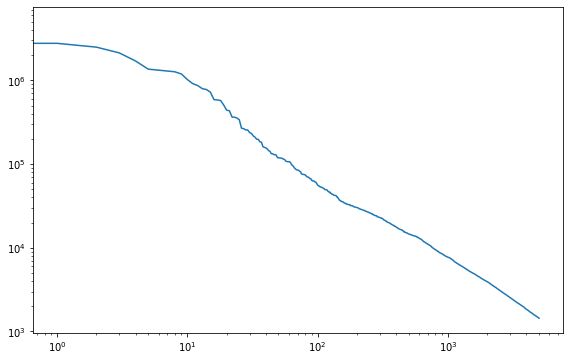

In [7]:
_ = plt.loglog(values)
plt.show()

**Benford's law**, also called the Newcomb–Benford law, the law of anomalous numbers, or the first-digit law, is an observation about the frequency distribution of leading digits in many real-life sets of numerical data.

Counter({1: 1705, 2: 1332, 3: 673, 4: 450, 5: 283, 6: 192, 7: 157, 8: 126, 9: 82})


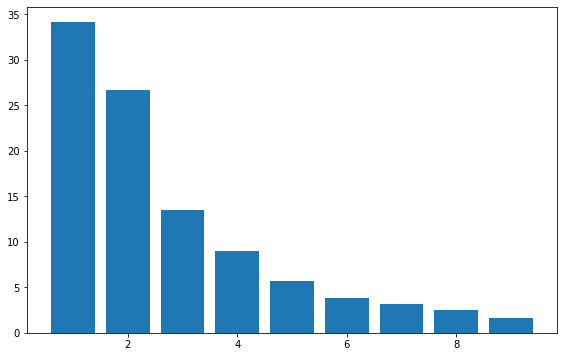

In [8]:
from collections import Counter
benford = Counter(int(str(item[1])[0]) for item in counter.most_common(5000))
print(benford)
percentage = np.array(list(benford.values()), dtype=float)
percentage /= percentage.sum()
_ = plt.bar(list(benford.keys()), percentage*100)

In [9]:
modelname = f'{CBOW_VECTORS_ROOT}/{DATASET_VERSION}.pt'
#modelname = f'{CBOW_VECTORS_ROOT}/{DATASET_VERSION}learntVectors.pt'
state_dict = torch.load(modelname, map_location=torch.device('cpu'))

In [10]:
state_dict.keys()

odict_keys(['emb.weight', 'lin.weight'])

In [11]:
input_word_vectors = state_dict['emb.weight'].numpy()
output_word_vectors = state_dict['lin.weight'].numpy()

In [12]:
token_vocab = Vocabulary()
token_vocab.load(f'{CBOW_VOCABULARY_ROOT}/ca.wiki.vocab')

In [13]:
class WordVectors:
    def __init__(self, vectors, vocabulary):
        # TODO
        self.vocabulary = vocabulary
        self.vectors = vectors
    
    
    def sim(self, x, y):
        '''Returns cosine similarity between two lists x and y'''
        #x_norm = np.sqrt(np.dot(x,x))
        x_norm = np.linalg.norm(x)
        #y_norm = np.sqrt(np.dot(y,y))
        y_norm = np.linalg.norm(y)
        if x_norm == 0 or y_norm == 0:
            return 0
        else: return np.dot(x,y)/(x_norm*y_norm)
    
    def most_similar(self, word, topn=10):
        ''' Return the topn words with the highest similarity to input word'''
        wordvec = self.vectors[self.vocabulary.get_index(word)]
        # Obtain the similarity with each word in the vocabulary
        similarities = [(name, self.sim(vec,wordvec)) for (name,vec) in zip(self.vocabulary.idx2token,self.vectors)]
        # Return the topn words with the highest similarity
        return sorted(similarities,key = lambda x: -x[1])[1:topn+1]

    def analogy(self, x1, x2, y1, topn=5, keep_all=False):
        # If keep_all if False we remove the input words (x1, x2, y1) from the returned closed words
        # Get the word vectors for each word
        vecx1 = self.vectors[self.vocabulary.get_index(x1)]
        vecx2 = self.vectors[self.vocabulary.get_index(x2)]
        vecy1 = self.vectors[self.vocabulary.get_index(y1)]
        vecy2 = vecx2 - vecx1 + vecy1 # Compute the "analogy point"
        # Get the most similar words from the "analogy point"
        if keep_all:
            similarities = [(name, self.sim(vec,vecy2)) for (name,vec) in zip(self.vocabulary.idx2token,self.vectors)]
        else:
            similarities = [(name, self.sim(vec,vecy2)) for (name,vec) in zip(self.vocabulary.idx2token,self.vectors) if name not in [x1,x2,y1]]
        return sorted(similarities,key = lambda x: -x[1])[:topn]

In [14]:
model1 = WordVectors(input_word_vectors, token_vocab)
model2 = WordVectors(output_word_vectors, token_vocab)

In [15]:
model1.most_similar('català')

[('valencià', 0.8694966),
 ('basc', 0.78099537),
 ('mallorquí', 0.7442114),
 ('gallec', 0.7043113),
 ('andalús', 0.67710865),
 ('espanyol', 0.64338785),
 ('neerlandès', 0.62412465),
 ('aragonès', 0.5999063),
 ('txec', 0.5868822),
 ('xilè', 0.583892)]

In [16]:
model2.analogy('França', 'francès', 'Polònia')

[('rus', 0.9535034),
 ('polonès', 0.95270663),
 ('portuguès', 0.94084746),
 ('turc', 0.93754303),
 ('italià', 0.9371083)]

### First we do a generic evaluation

Good examples:

In [17]:
model2.analogy('0', '1', '2')

[('3', 0.9136957),
 ('4', 0.90190166),
 ('6', 0.89479685),
 ('5', 0.88276887),
 ('7', 0.88276505)]

In [18]:
model1.most_similar('rei')

[('monarca', 0.83487535),
 ('príncep', 0.72772914),
 ('regne', 0.7110699),
 ('Rei', 0.7052473),
 ('sultà', 0.685487),
 ('cabdill', 0.6854348),
 ('tsar', 0.67964375),
 ('califa', 0.66172945),
 ('pretendent', 0.6485082),
 ('faraó', 0.6410272)]

In [19]:
model2.analogy('rei', 'reina', 'príncep')

[('princesa', 0.9594974),
 ('senyora', 0.94720423),
 ('comtessa', 0.93902147),
 ('promesa', 0.9367481),
 ('Verge', 0.93619454)]

In [20]:
model2.analogy('gran', 'petit', 'sec')

[('extern', 0.941792),
 ('humit', 0.94044673),
 ('pesat', 0.9383421),
 ('perillós', 0.93823665),
 ('tranquil', 0.9379639)]

In [21]:
model1.most_similar('cargol')

[('caragol', 0.6599287),
 ('capçal', 0.5760337),
 ('bedoll', 0.5333225),
 ('barril', 0.5327309),
 ('pneumàtic', 0.5246113),
 ('cistell', 0.5210371),
 ('falguera', 0.51844853),
 ('camió', 0.5077303),
 ('cafeïna', 0.5047261),
 ('rotor', 0.5041223)]

In [22]:
model1.most_similar('ratolí')

[('gos', 0.6306089),
 ('mico', 0.6034023),
 ('botó', 0.59301186),
 ('porc', 0.57390374),
 ('gat', 0.5716926),
 ('cervell', 0.5687897),
 ('micròfon', 0.56136334),
 ('filtre', 0.5606296),
 ('cuc', 0.5594078),
 ('pin', 0.5556143)]

Bad examples:

In [23]:
model1.most_similar('sabata')

[('màscara', 0.67350644),
 ('cinta', 0.6489823),
 ('pell', 0.6406212),
 ('safata', 0.61697656),
 ('planxa', 0.6139086),
 ('cistella', 0.6125013),
 ('bossa', 0.6111405),
 ('carcassa', 0.6092102),
 ('camisa', 0.592758),
 ('barra', 0.59126544)]

In [24]:
model2.analogy('juny', 'juliol', 'septembre')

[('hua', 0.9910463),
 ('Crockett', 0.99100065),
 ('Rik', 0.9909363),
 ('Heilbronn', 0.99090624),
 ('Rein', 0.9908806)]

In [25]:
model2.analogy('10', '20', '30')

[('25', 0.97883403),
 ('24', 0.9717788),
 ('21', 0.9716092),
 ('16', 0.9699173),
 ('23', 0.9697214)]

Now let's look for biases in the analogies

In [26]:
model2.analogy('pare', 'treballador', 'mare')

[('criada', 0.9340185),
 ('promesa', 0.9318797),
 ('companya', 0.9318301),
 ('secretària', 0.9318013),
 ('infermera', 0.93136454)]

In [27]:
model2.analogy('negre', 'pobre', 'blanc')

[('ric', 0.9325105),
 ('Morgan', 0.9248677),
 ('humil', 0.924194),
 ('senzilla', 0.92383283),
 ('rica', 0.9234225)]

Let's try to visualize relations, through dimensionality reduction

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.manifold import TSNE
tsne_dims = TSNE(n_components=2,random_state = 1).fit_transform(model2.vectors[:1500])

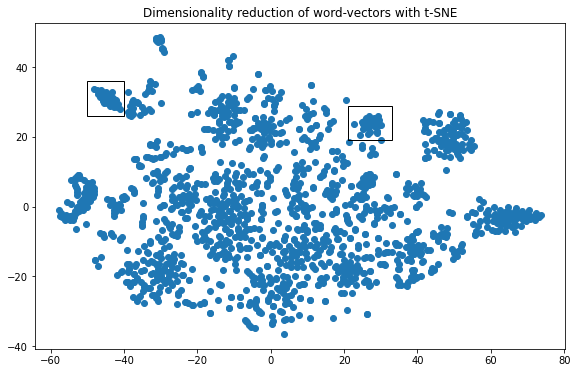

In [29]:
plt.scatter(x = tsne_dims[:,0],y = tsne_dims[:,1])
plt.title("Dimensionality reduction of word-vectors with t-SNE")
ax = plt.gca()
ax.add_patch(patches.Rectangle((-50, 26), 10, 10, fill = False))
ax.add_patch(patches.Rectangle((21, 19), 12, 10, fill = False))

In [30]:
# Cluster on the top left of the plot. Represent the numbers
x1,x2,y1,y2 = -50, -40, 26, 36
for i in range(len(tsne_dims)):
    if tsne_dims[i][0] > x1 and tsne_dims[i][0] < x2 and tsne_dims[i][1] > y1 and tsne_dims[i][1] < y2:
        print(model2.vocabulary.idx2token[i],',',sep = '',end = ' ')

1, 2, 3, 4, 5, 6, 8, 7, 10, 12, 20, 9, 15, 16, 11, 14, 13, 30, 18, 17, 25, 24, 19, 21, 22, 28, 23, 27, 26, 29, 31, 

In [31]:
# Cluster on the middle top. Represent the prepositions and conjuntions
x1,x2,y1,y2 = 21, 33, 19, 29
for i in range(len(tsne_dims)):
    if tsne_dims[i][0] > x1 and tsne_dims[i][0] < x2 and tsne_dims[i][1] > y1 and tsne_dims[i][1] < y2:
        print(model2.vocabulary.idx2token[i],',',sep = '',end = ' ')

<unk>, de, la, i, a, el, d, l, que, en, del, per, un, una, les, amb, al, els, es, com, dels, més, o, no, entre, també, però, 